![Banner](./Datasets/banner.png)

This Jupyter Notebook is a step-by-step guide to reconstruct Canopy Water Content (CWC) records from dendrometer data. This model was developped in the context of the M.Sc. Thesis Research _"Forest Health Monitoring: Dendrometers as Continuous Canopy Water Content Sensors for the Validation of Microwave Remote Sensing Products"_ (Guglielmi, 2025). Example datasets used in the thesis are provided in the /Datasets folder to reproduce this research. 

### Table of Content: 

0. Required libraries
1. Pre-process Dendrometer data
2. Detrend dendrometer data for growth
3. Pre-Process LFMC data
4. Create constrain curves
5. Constraint TWD curves
6. Validate with field data
7. References

# 0. Required libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import Normalize
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import widgets, Checkbox, VBox
from IPython.display import display, clear_output
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#from dtaidistance import dtw
from scipy.stats import spearmanr
from netCDF4 import Dataset
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import cartopy.io.shapereader as shpreader
#import os
#from glob import glob


# 1. Pre-process and load dendrometer data

The dendrometer data needs to be cleaned for sensors-induced errors and outliers. This can be done manually in Excel, or using algorithms such as the R package 'DendRoAnalyst' (Aryal 2020). This pre-processing is not included in this model. To apply this model to your dendrometer data, the dataset must have the following format:


| timestamp | dendro_1 | dendro_2 | dendro_3 | ... |
|------|---------|------------|------------|---------|
| 2024-01-01  12:00:00 PM   | 60.12   | 55.67      | 50.34      | ....|
| 2024-01-01  12:30:00 PM   | 60.12   | 55.67      | 50.34      | ....|

As example, the _dendrometer_speulderbos.csv_ file available in this folder can be used. The file include the records of three dendrometers CR3000_Dendro (band), CR1000_Nakton (point), and CR3000_Nakton (point) between March 2024 and January 2025 (discontinuous), mounted on Douglas Fir _Pseudotsuga menziesii_.

In [26]:
path_to_dendro_data = "./Datasets/dendrometer_speulderbos.csv" # replace with the path to your dendrometer data if needed

In [27]:
# load the data
dendrometer_data = pd.read_csv(path_to_dendro_data)
dendrometer_data.rename(columns={dendrometer_data.columns[0]: 'timestamp'}, inplace=True)
dendrometer_data['timestamp'] = pd.to_datetime(dendrometer_data['timestamp'], errors='coerce')
dendrometer_data["CR3000_Dendro"] = dendrometer_data["CR3000_Dendro"] / (2 * np.pi) # converts stem circumpherence into stem radius for the band dendrometer for comparability with the point dendrometers

print(dendrometer_data.head())

            timestamp  CR1000_Nakton  CR3000_Dendro  CR3000_Nakton
0 2024-03-07 21:30:00            NaN       0.000000            NaN
1 2024-03-07 22:00:00            NaN      -0.139343            NaN
2 2024-03-07 22:30:00            NaN      -0.171531            NaN
3 2024-03-07 23:00:00            NaN      -0.290910            NaN
4 2024-03-07 23:30:00            NaN      -0.354470            NaN


In [28]:
rain_df = {
    'timestamp': [
        '2024-05-12', '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17',
        '2024-05-18', '2024-05-19', '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23',
        '2024-05-24', '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29',
        '2024-05-30', '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04',
        '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10',
        '2024-06-11', '2024-06-12'
    ],
    'Rainfall': [
        0, 0, 1, 0, 51, 2, 6, 62, 13, 0, 238, 3, 28, 217, 5, 64, 48, 205, 107, 6, 
        126, 2, 1, 0, 56, 0, 0, 0, 0, 37, 226, 27
    ],
    'Evapotranspiration': [
        47, 39, 49, 28, 24, 19, 26, 28, 29, 32, 18, 26, 10, 22, 27, 30, 30, 21, 21, 25,
        12, 29, 20, 24, 34, 27, 37, 30, 34, 13, 30, 27
    ]
}
rain_df = pd.DataFrame(rain_df)
rain_df['timestamp'] = pd.to_datetime(rain_df['timestamp'])


Optional: visualize the data for inspection

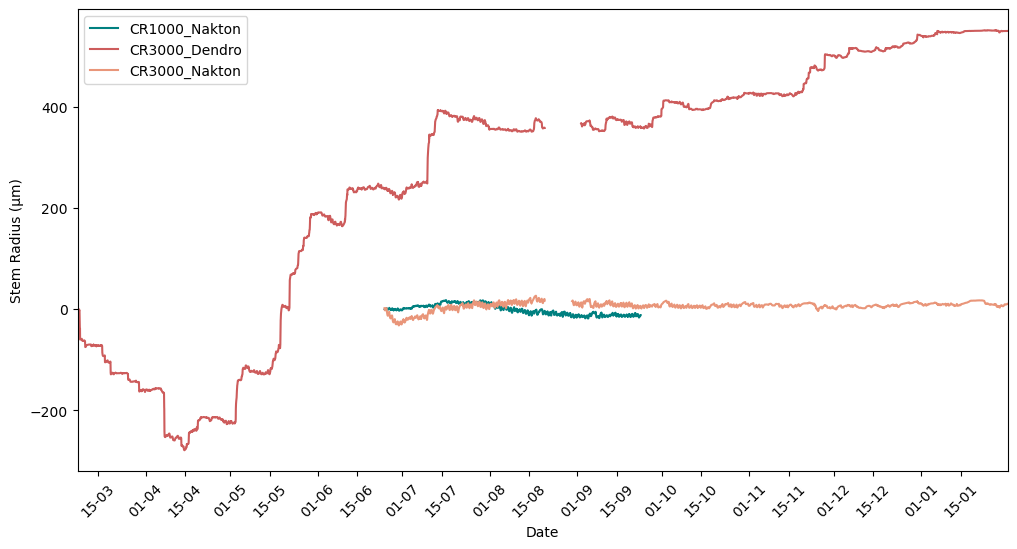

In [29]:
dendrometer_data['timestamp'] = pd.to_datetime(dendrometer_data['timestamp'])

plt.figure(figsize=(12, 6))
plt.plot(dendrometer_data['timestamp'], dendrometer_data['CR1000_Nakton'], label='CR1000_Nakton', linestyle='-', color='teal')
plt.plot(dendrometer_data['timestamp'], dendrometer_data['CR3000_Dendro'], label='CR3000_Dendro', linestyle='-', color='indianred')
plt.plot(dendrometer_data['timestamp'], dendrometer_data['CR3000_Nakton'], label='CR3000_Nakton', linestyle='-', color='darksalmon')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1, 15])) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlim(dendrometer_data['timestamp'].min(), dendrometer_data['timestamp'].max())
plt.xlabel("Date")
plt.ylabel("Stem Radius (μm)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 2. Separate water-induced from growth-induced stem radius variations

The Zero-Growth approach is a method to separate growth-induced stem shrinkage from water-induced stem variations (Zweifel, 2016). The detrended dendrometer data results in a  Tree Water Deficit (TWD) curve. 

In [30]:
column_names = ['CR3000_Nakton', 'CR3000_Dendro', 'CR1000_Nakton'] # adapt to dendrometer of interest

In [31]:
# detrend each column and create a new TWD_{column_name} column in the dendrometer_data dataframe

def calculate_growth_and_twd(data, column):
    result = data[['timestamp', column]].copy()
    result.rename(columns={column: f'{column}_initial'}, inplace=True)
    result[f'{column}_initial'] = pd.to_numeric(result[f'{column}_initial'], errors='coerce')

    result['growth'] = np.nan

    # ZG approach
    for i in range(len(result)):
        if i == 0:
            if not np.isnan(result.loc[i, f'{column}_initial']):
                result.loc[i, 'growth'] = result.loc[i, f'{column}_initial']
        else:
            if not np.isnan(result.loc[i, f'{column}_initial']):
                if not np.isnan(result.loc[i - 1, 'growth']):
                    if result.loc[i, f'{column}_initial'] > result.loc[i - 1, 'growth']:
                        result.loc[i, 'growth'] = result.loc[i, f'{column}_initial']
                    else:
                        result.loc[i, 'growth'] = result.loc[i - 1, 'growth']
                else:
                    result.loc[i, 'growth'] = result.loc[i, f'{column}_initial']
            else:
                result.loc[i, 'growth'] = result.loc[i - 1, 'growth']

    result[f'growth_{column}'] = result['growth']
    result[f'TWD_{column}'] = result[f'{column}_initial'] - result['growth']

    return result[[f'growth_{column}', f'TWD_{column}']]

for col in column_names:
    growth = calculate_growth_and_twd(dendrometer_data, col)
    dendrometer_data = pd.concat([dendrometer_data, growth], axis=1)

print(dendrometer_data.head(5))

            timestamp  CR1000_Nakton  CR3000_Dendro  CR3000_Nakton  \
0 2024-03-07 21:30:00            NaN       0.000000            NaN   
1 2024-03-07 22:00:00            NaN      -0.139343            NaN   
2 2024-03-07 22:30:00            NaN      -0.171531            NaN   
3 2024-03-07 23:00:00            NaN      -0.290910            NaN   
4 2024-03-07 23:30:00            NaN      -0.354470            NaN   

   growth_CR3000_Nakton  TWD_CR3000_Nakton  growth_CR3000_Dendro  \
0                   NaN                NaN                   0.0   
1                   NaN                NaN                   0.0   
2                   NaN                NaN                   0.0   
3                   NaN                NaN                   0.0   
4                   NaN                NaN                   0.0   

   TWD_CR3000_Dendro  growth_CR1000_Nakton  TWD_CR1000_Nakton  
0           0.000000                   NaN                NaN  
1          -0.139343                   NaN

Optional: Visualize the data

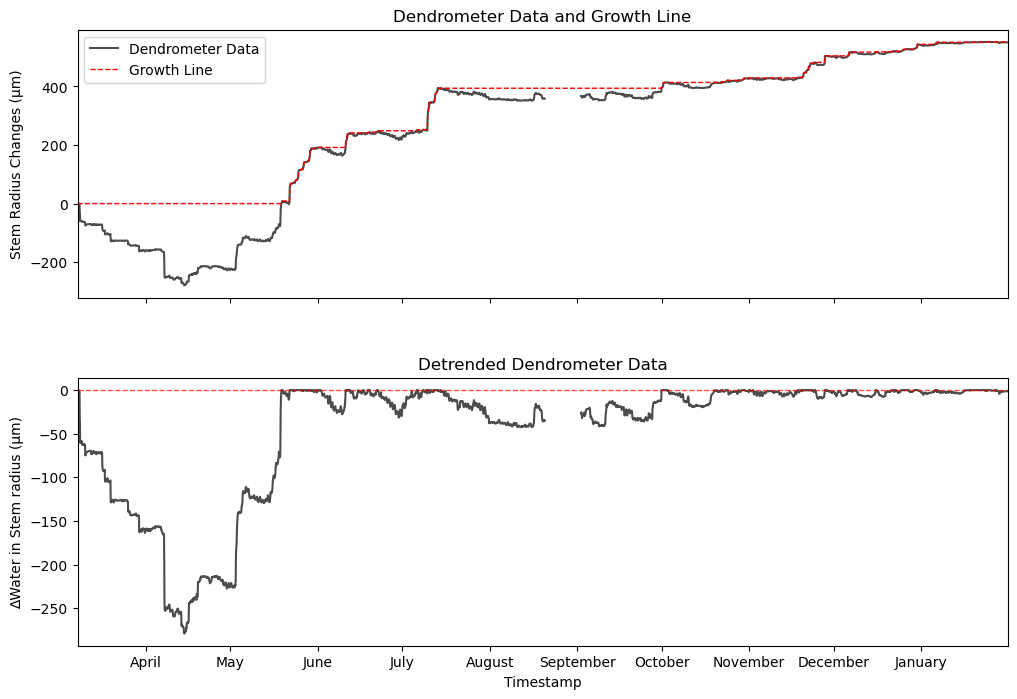

In [32]:
dendro_to_plot = 'CR3000_Dendro' # replace with your column of interest

column_growth = f'growth_{dendro_to_plot}'
column_twd = f'TWD_{dendro_to_plot}'
def visualize_growth_and_twd(data, column_initial, column_growth, column_twd):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'hspace': 0.3})

    axs[0].plot(data['timestamp'], data[column_initial], label='Dendrometer Data', linestyle='-', alpha=0.7, color='black')
    axs[0].plot(data['timestamp'], data[column_growth], label='Growth Line', linestyle='--', linewidth=1, color='red')
    axs[0].set_ylabel('Stem Radius Changes (μm)')
    axs[0].set_title('Dendrometer Data and Growth Line')
    axs[0].legend()

    axs[1].plot(data['timestamp'], data[column_twd], color='black', alpha=0.7)
    axs[1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    axs[1].set_ylabel('∆Water in Stem radius (μm)')
    axs[1].set_xlabel('Timestamp') 
    axs[1].set_title('Detrended Dendrometer Data')

    start_date = data['timestamp'].min()
    end_date = data['timestamp'].max()
    axs[1].set_xlim(start_date, end_date)
    axs[1].xaxis.set_major_locator(mdates.MonthLocator()) 
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%B'))
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=0, ha="center")
    
    plt.show()

visualize_growth_and_twd(dendrometer_data, dendro_to_plot, column_growth, column_twd)

# 3. Pre-process LFMC data

For the next step, the Globe LFMC 2.0 Dataset (Yebra et al. 2024) was used. This dataset comprises more 200.000 in situ measurements from vegetation Life Fuel Moisture Content from 15 countries. This database will be used to estimate the typical physiological maxima and minima of Gravimetric Moisture Content (GMC) your vegetation-type of interests can reach throughout the year. The database can be downloaded from : https://springernature.figshare.com/collections/_/6980418.

For the next steps, a sub-dataset from the Globe LFMC 2.0 will be created. The dataset should be the representative of the studied vegetation. Although the Globe LFMC 2.0 is a substantive database, it is limited and the specific region or species of interest might not be covered sufficently. For this reason, you should also consider:

- What is the vegetation type or species I am studying?
- What are the climatic and meteorologic conditions of my study area? (For example, according to the Köppen Climate Classification, (Beck 2018))
- What is their growing pattern (e.g. start and end of growing season)?
- What are other species that could be representative of my species of interets?
- What are other regions of the world with similar environmental and climatic condition? 

It is possible to directly filter the Globe LFMC 2.0 in Excel using the filter tool.  As an alternative, you can use this code to filter the LFMC dataset based on location and species. At the end, you can save the subdataset as a csv file. Run again the cell to create a new sub dataset. The csv file must be renamed or it will be written over as the code is re-run. 

In [10]:
# load Globe LFMC 2.0
path_to_Globe_LFMC = "./Datasets/Globe-LFMC-2.0%20final.xlsx" # change to correct path to the db
sheet_name = "LFMC data" 
df = pd.read_excel(path_to_Globe_LFMC, sheet_name=sheet_name)

In [11]:
# run this code to create (or clear) the filter interface 

filtered_df = pd.DataFrame()
unique_countries = df['Country'].dropna().unique()
country_checkboxes = [Checkbox(value=False, description=country) for country in sorted(unique_countries)]

def apply_filter_callback(_):
    clear_output(wait=True)
    selected_countries = [checkbox.description for checkbox in country_checkboxes if checkbox.value]
    if not selected_countries:
        print("No countries selected. Please select at least one country.")
        display_country_widgets()
        return
    print(f"Filter applied, selection: {selected_countries}")
    
    filtered_regions = df[df['Country'].isin(selected_countries)]['State/Region'].dropna().unique()
    region_checkboxes = [Checkbox(value=False, description=region) for region in sorted(filtered_regions)]
    
    def apply_region_filter_callback(_):
        clear_output(wait=True)
        selected_regions = [checkbox.description for checkbox in region_checkboxes if checkbox.value]
        if not selected_regions:
            print("No regions selected. Please select at least one region.")
            display_region_widgets()
            return
        
        print(f"Filter applied, selection: Countries - {selected_countries}, Regions - {selected_regions}")
        
        filtered_species = df[(df['Country'].isin(selected_countries)) & 
                              (df['State/Region'].isin(selected_regions))]['Species functional type'].dropna().unique()
        
        species_checkboxes = [Checkbox(value=False, description=species) for species in sorted(filtered_species)]
        
        def apply_species_filter_callback(_):
            clear_output(wait=True)
            selected_species = [checkbox.description for checkbox in species_checkboxes if checkbox.value]
            if not selected_species:
                print("No species functional types selected. Please select at least one.")
                display_species_widgets()
                return
            
            print(f"Filter applied, selection: Countries - {selected_countries}, Regions - {selected_regions}, Species Functional Types - {selected_species}")
            
            filtered_species_collected = df[(df['Country'].isin(selected_countries)) & 
                                            (df['State/Region'].isin(selected_regions)) & 
                                            (df['Species functional type'].isin(selected_species))]['Species collected'].dropna().unique()
            
            species_collected_checkboxes = [Checkbox(value=False, description=species) for species in sorted(filtered_species_collected)]
            
            def apply_species_collected_filter_callback(_):
                clear_output(wait=True) 
                selected_species_collected = [checkbox.description for checkbox in species_collected_checkboxes if checkbox.value]
                print(f"Filter applied, selection: Countries - {selected_countries}, Regions - {selected_regions}, Species Functional Types - {selected_species}, Species Collected - {selected_species_collected}")
    
                global filtered_df 
                filtered_df = df[
                    (df['Country'].isin(selected_countries)) &
                    (df['State/Region'].isin(selected_regions)) &
                    (df['Species functional type'].isin(selected_species)) &
                    (df['Species collected'].isin(selected_species_collected))
                ]               


                display(filtered_df.head())
                def save_filtered_data(_):
                    filtered_df.to_csv("filtered_LFMC.csv", index=False)
                    print("Filtered data has been saved as 'filtered_LFMC.csv'")
                
                save_button = widgets.Button(
                    description="Save to CSV",
                    button_style="success",
                    tooltip="Click to save the filtered DataFrame to a CSV file"
                )
                save_button.on_click(save_filtered_data)
                display(save_button)

            apply_species_collected_button = widgets.Button(
                description="Apply Species Collected Filter",
                button_style="success",
                tooltip="Click to apply the species collected filter"
            )
            apply_species_collected_button.on_click(apply_species_collected_filter_callback)
            
            display(widgets.Label(value="Select Species Collected:"))
            display(VBox(species_collected_checkboxes))
            display(apply_species_collected_button)
        
        apply_species_button = widgets.Button(
            description="Apply Species Functional Type Filter",
            button_style="success",
            tooltip="Click to apply the species functional type filter"
        )
        apply_species_button.on_click(apply_species_filter_callback)
        
        def display_species_widgets():
            display(widgets.Label(value="Select Species Functional Type:"))
            display(VBox(species_checkboxes))
            display(apply_species_button)
        
        display_species_widgets()
    
    apply_region_button = widgets.Button(
        description="Apply Region Filter",
        button_style="success",
        tooltip="Click to apply the region filter"
    )
    apply_region_button.on_click(apply_region_filter_callback)
    
    def display_region_widgets():
        display(widgets.Label(value="Select Regions:"))
        display(VBox(region_checkboxes))
        display(apply_region_button)
    
    display_region_widgets()

apply_button = widgets.Button(
    description="Apply Filter",
    button_style="success",
    tooltip="Click to apply the filter"
)
apply_button.on_click(apply_filter_callback)

def display_country_widgets():
    display(widgets.Label(value="Select Countries:"))
    display(VBox(country_checkboxes))
    display(apply_button)

display_country_widgets()

Label(value='Select Countries:')

Button(button_style='success', description='Apply Filter', style=ButtonStyle(), tooltip='Click to apply the fi…

# 4. Create constraint curves

The sub-dataset created in step 3. contains information about seasonal variations of LFMC for the species of interest. The LFMC is converted into Gravimetric Moisture Content (GMC, %) units for analysis.

In the context of the original thesis research, several sub-datasets were created and compared with the expected seasonal pattern of increase and decrease of CWC for Douglas Firs _Pseudotsuga menziesii_, and the most representative one was selected for further analysis. The following code allows to reproduce those steps and to create the constrained curves out of the selected sub-dataset. All data is available in the Datasets folder for reproduction. 

## 4.1. Compare sub-datasets

In [33]:
filtered_lfmc_path = "./Datasets/filtered_globe_lfmc.xlsx"

In [34]:
# load the sub-datasets
combination_A = pd.read_excel(filtered_lfmc_path, sheet_name='A', usecols=['LFMC value (%)', 'Site name', 'Sampling date (YYYYMMDD)'])
combination_B = pd.read_excel(filtered_lfmc_path, sheet_name='B', usecols=['LFMC value (%)', 'Site name', 'Sampling date (YYYYMMDD)'])
combination_C = pd.read_excel(filtered_lfmc_path, sheet_name='C', usecols=['LFMC value (%)', 'Site name', 'Sampling date (YYYYMMDD)'])
for df in [combination_A, combination_B, combination_C]:
    df.rename(columns={'LFMC value (%)': 'lfmc', 'Site name': 'site', 'Sampling date (YYYYMMDD)': 'timestamp'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d')

combination_D = pd.concat([combination_A, combination_C], ignore_index=True)

Plot the sub-datasets to identify which one is the most representative:

/var/folders/0j/0ng55b7x7s99l0xjltdn28_h0000gn/T/ipykernel_2821/3910700040.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Month').apply(remove_outliers).reset_index(drop=True)


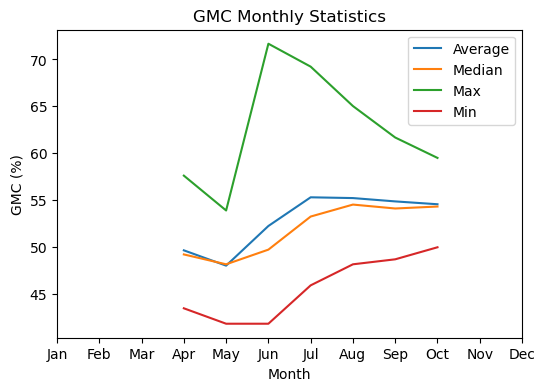

/var/folders/0j/0ng55b7x7s99l0xjltdn28_h0000gn/T/ipykernel_2821/3910700040.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Month').apply(remove_outliers).reset_index(drop=True)


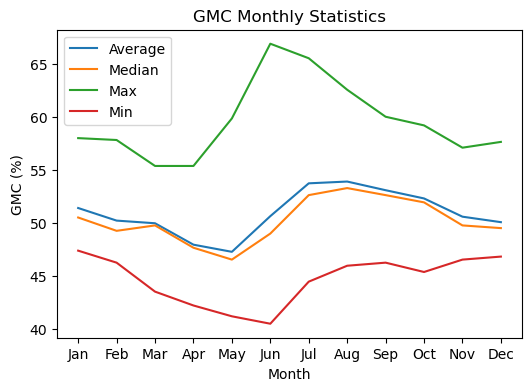

/var/folders/0j/0ng55b7x7s99l0xjltdn28_h0000gn/T/ipykernel_2821/3910700040.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Month').apply(remove_outliers).reset_index(drop=True)


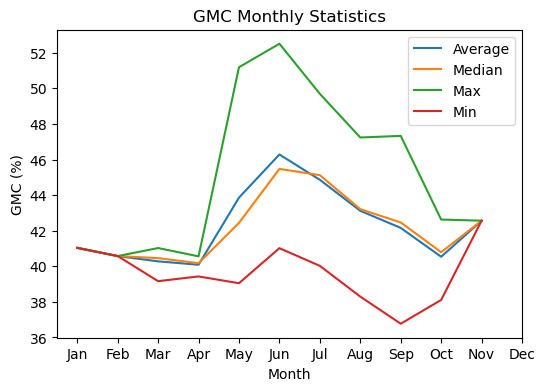

/var/folders/0j/0ng55b7x7s99l0xjltdn28_h0000gn/T/ipykernel_2821/3910700040.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Month').apply(remove_outliers).reset_index(drop=True)


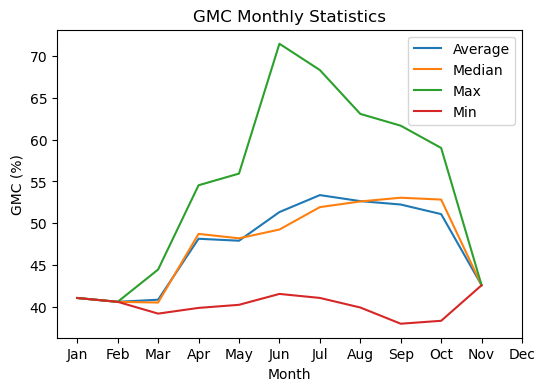

In [35]:
metric = 'GMC' # write 'LFMC' if you want to look at LFMC variation instead of GMC variations
# outlier removal threshold
upper_percentile = 0.97  
lower_percentile = 0.03
sub_datasets_to_plot = [combination_A, combination_B, combination_C, combination_D] 


def load_data(df_combined):
    df = df_combined.copy()
    df['Month'] = df['timestamp'].dt.month
    def remove_outliers(group):
        lower_bound = group['lfmc'].quantile(lower_percentile) 
        upper_bound = group['lfmc'].quantile(upper_percentile)
        return group[(group['lfmc'] >= lower_bound) & (group['lfmc'] <= upper_bound)]
    df = df.groupby('Month').apply(remove_outliers).reset_index(drop=True)
    return df

def calculate_monthly_statistics(df, metric):
    monthly_stats = df.groupby('Month')['lfmc'].agg(
        Average='mean',
        Median='median',
        Min='min',
        Max='max'
    ).reset_index()
    if metric == 'GMC':  # transforms LFMC into GMC
        monthly_stats['Average'] = (100 * monthly_stats['Average']) / (100 + monthly_stats['Average'])
        monthly_stats['Median'] = (100 * monthly_stats['Median']) / (100 + monthly_stats['Median'])
        monthly_stats['Min'] = (100 * monthly_stats['Min']) / (100 + monthly_stats['Min'])
        monthly_stats['Max'] = (100 * monthly_stats['Max']) / (100 + monthly_stats['Max'])
    return monthly_stats

def main1(combinations, metric):
    df = load_data(combinations)
    monthly_stats = calculate_monthly_statistics(df, metric)
    monthly_stats = monthly_stats.sort_values('Month')
    plt.figure(figsize=(6, 4))
    plt.plot(monthly_stats['Month'], monthly_stats['Average'], label='Average')
    plt.plot(monthly_stats['Month'], monthly_stats['Median'], label='Median')
    plt.plot(monthly_stats['Month'], monthly_stats['Max'], label='Max')
    plt.plot(monthly_stats['Month'], monthly_stats['Min'], label='Min')
    plt.xlabel('Month')
    plt.ylabel(f'{metric} (%)')
    plt.title(f'{metric} Monthly Statistics')
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.show()


for combinations in sub_datasets_to_plot:
    main1(combinations, metric)


## 4.2. Create the constraint curves

The _Max, AvgMax, Average, Min,_ and _AvgMin_ constraint curves will be created from the selected sub-dataset.

In [36]:
sub_dataset = combination_B # selected subpdataset

/var/folders/0j/0ng55b7x7s99l0xjltdn28_h0000gn/T/ipykernel_2821/3910700040.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Month').apply(remove_outliers).reset_index(drop=True)


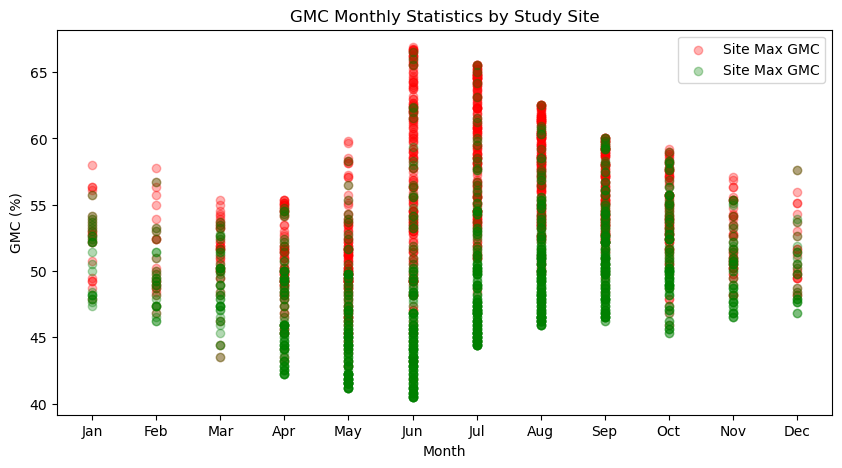

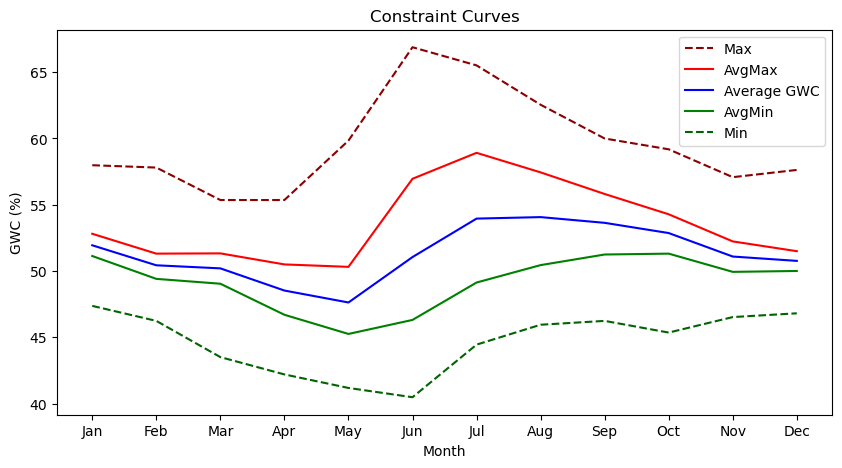

Month           1          2          3          4          5          6   \
Max      57.983193  57.805907  55.357143  55.357143  59.839357  66.887417   
AvgMax   52.810467  51.311524  51.330663  50.497574  50.313511  56.959510   
AvgMin   51.132345  49.407004  49.040815  46.697915  45.251604  46.309040   
Min      47.368421  46.236559  43.502825  42.196532  41.176471  40.476190   
Average  51.941570  50.432040  50.200015  48.526762  47.625189  51.052390   

Month           7          8          9          10         11         12  
Max      65.517241  62.546816  60.000000  59.183673  57.081545  57.627119  
AvgMax   58.918865  57.443478  55.812829  54.280269  52.234089  51.496511  
AvgMin   49.131265  50.445621  51.246020  51.311043  49.935910  50.002666  
Min      44.444444  45.945946  46.236559  45.355191  46.524064  46.808511  
Average  53.955285  54.067726  53.635749  52.864529  51.092559  50.764442  


In [37]:
def analyze_study_sites_and_times(df):
    grouped = df.groupby('Month')
    for month, group in grouped:
        unique_sites = group['site'].nunique() #to know how many individual study sites there are per month, uncomment the next lines
        #print(f"\nmonth: {month}")
        #print(f"  number of unique study sites: {unique_sites}")

def plot_lfmc_by_month_and_site(df):
    site_stats = df.groupby(['Month', 'site'])['lfmc'].agg(
        Max='max',
        Average='mean',
        Min = 'min'
    ).reset_index()
    site_stats['Average'] = (100* site_stats['Average']) / (100 + site_stats['Average'])
    site_stats['Max'] = (100* site_stats['Max']) / (100 + site_stats['Max'])
    site_stats['Min'] = (100* site_stats['Min']) / (100 + site_stats['Min'])

    plt.figure(figsize=(10, 5))

    for month in site_stats['Month'].unique():
        month_data = site_stats[site_stats['Month'] == month]

        plt.scatter([month] * len(month_data), month_data['Max'], 
                    color='red', alpha=0.3, label='Site Max GMC' if month == 1 else "")

       #plt.scatter([month] * len(month_data), month_data['Average'], # uncomment to plot average points as well
        #            color='blue', alpha=0.3, label='Average GMC' if month == 1 else "")

        plt.scatter([month] * len(month_data), month_data['Min'], 
                    color='green', alpha=0.3, label='Site Max GMC' if month == 1 else "")

    plt.xlabel('Month')
    plt.ylabel('GMC (%)')
    plt.title('GMC Monthly Statistics by Study Site')
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])                                       
    plt.legend()
    plt.show()

def plot_average_max_min_by_month(site_stats):
    monthly_stats = site_stats.groupby('Month').agg(
        AvgMax=('Max', 'mean'),
        AvgMin=('Min', 'mean'),
        Max=('Max', 'max'),  
        Min=('Min', 'min') 
    ).reset_index()
    average_values = site_stats.groupby('Month')['Average'].mean().reset_index()

    plt.figure(figsize=(10, 5))
    plt.plot(monthly_stats['Month'], monthly_stats['Max'], linestyle='--', 
             color='darkred', label='Max')
    plt.plot(monthly_stats['Month'], monthly_stats['AvgMax'], linestyle='-', 
             color='red', label='AvgMax')
    
    plt.plot(average_values['Month'], average_values['Average'], linestyle='-', 
             color='blue', label='Average GWC')
    plt.plot(monthly_stats['Month'], monthly_stats['AvgMin'], linestyle='-', 
             color='green', label='AvgMin')
    plt.plot(monthly_stats['Month'], monthly_stats['Min'], linestyle='--', 
             color='darkgreen', label='Min')

    plt.xlabel('Month')
    plt.ylabel('GWC (%)')
    plt.title('Constraint Curves')
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])                                
    plt.legend()
    plt.show()

def generate_seasonal_GWC_df(site_stats):
    monthly_stats = site_stats.groupby('Month').agg(
        Max=('Max', 'max'),
        AvgMax=('Max', 'mean'),
        AvgMin=('Min', 'mean'),
        Min=('Min', 'min')
    ).reset_index()

    average_values = site_stats.groupby('Month')['Average'].mean().reset_index()
    seasonal_GWC_df = pd.merge(monthly_stats, average_values, on='Month')
    seasonal_GWC_df = seasonal_GWC_df.set_index('Month').T 
    return seasonal_GWC_df

def main_function(sub_dataset):
    global summary_table
    df = load_data(sub_dataset)
    analyze_study_sites_and_times(df)
    plot_lfmc_by_month_and_site(df)

    site_stats = df.groupby(['Month', 'site'])['lfmc'].agg(
        Max='max',
        Min='min',
        Average='mean'
    ).reset_index()
    site_stats['Max'] = (100* site_stats['Max']) / (100 + site_stats['Max'])
    site_stats['Min'] = (100* site_stats['Min']) / (100 + site_stats['Min'])
    site_stats['Average'] = (100* site_stats['Average']) / (100 + site_stats['Average'])

    plot_average_max_min_by_month(site_stats)
    summary_table = generate_seasonal_GWC_df(site_stats)
    print(summary_table)

main_function(sub_dataset)


Interpolate the constraints values to the daily-scale:

In [38]:
dates = []
columns = ['Max', 'AvgMax', 'Average', 'AvgMin', 'Min']
daily_stats = {col: [] for col in columns}

for i in range(1, 12): 
    current_month_start = pd.Timestamp(f"2024-{i:02d}-01")
    next_month_start = pd.Timestamp(f"2024-{i + 1:02d}-01")
    num_days = (next_month_start - current_month_start).days
    daily_dates = [current_month_start + pd.Timedelta(days=j) for j in range(num_days)]
    dates.extend(daily_dates)

    for col in columns:
        current_month_value = summary_table.loc[col, i]
        next_month_value = summary_table.loc[col, i + 1]
        interpolated_values = np.linspace(current_month_value, next_month_value, num_days)
        daily_stats[col].extend(interpolated_values)
last_month_start = pd.Timestamp("2024-12-01")
dates.extend([last_month_start + pd.Timedelta(days=j) for j in range(31)]) 
for col in columns:
    daily_stats[col].extend([summary_table.loc[col, 12]] * 31)

boundaries_df = pd.DataFrame(daily_stats, index=dates)
print(boundaries_df.head(10))

#boundaries_df.to_csv( "./Datasets/boundaries_data.csv", index=True) #save it as a file if needed


                  Max     AvgMax    Average     AvgMin        Min
2024-01-01  57.983193  52.810467  51.941570  51.132345  47.368421
2024-01-02  57.977284  52.760503  51.891252  51.074834  47.330692
2024-01-03  57.971374  52.710538  51.840935  51.017323  47.292964
2024-01-04  57.965465  52.660573  51.790617  50.959811  47.255235
2024-01-05  57.959555  52.610608  51.740299  50.902300  47.217506
2024-01-06  57.953646  52.560644  51.689982  50.844788  47.179777
2024-01-07  57.947736  52.510679  51.639664  50.787277  47.142049
2024-01-08  57.941827  52.460714  51.589346  50.729766  47.104320
2024-01-09  57.935917  52.410749  51.539029  50.672254  47.066591
2024-01-10  57.930007  52.360784  51.488711  50.614743  47.028862


# 5. Constrain TWD curves

The _Max, AvgMax, Average, Min_ and _AvgMin_ curves can now serve as Upper and Lower constraints for the TWD curves, enabling the generation of multiples CWC outputs using different combinations of upper and lower constraints. The following code assigns this Upper and Lower constraints using to these combinations:



| Combination n°| Upper Constraint | Lower Constraint | 
|---------------|------------------|------------------|
| 1             | Max              | AvgMax           | 
| 2             | Max              | Average          |
| 3             | Max              | AverageMin       | 
| 4             | Max              | Min              | 
| 5             | AvgMax           | Average          | 
| 6             | AvgMax           | AverageMin       | 
| 7             | AvgMax           | Min              | 
| 8             | Average          | AverageMin       | 
| 9             | Average          | Min              |



Using the boundaries_df generated previously and the TWD curves generated in step 2, you can recreate record of GMC variations using the following code. 

**!** The code can take 5+ min to run

In [39]:
TWD_to_constrain = ['TWD_CR3000_Nakton', 'TWD_CR3000_Dendro', 'TWD_CR1000_Nakton']

In [40]:
all_cwc_outputs = {}
pd.options.mode.chained_assignment = None  # removes slice warning

def constrain_twd(twd_curve, boundaries_df, upper, lower):
    twd_curve.loc[:, 'timestamp'] = pd.to_datetime(twd_curve['timestamp'])
    boundaries_df.index = pd.to_datetime(boundaries_df.index)
    boundaries_df['month'] = boundaries_df.index.month

    constrained_values = []

    #identify maximum and minimum TWD values monthly and interpolate linearly the values in between
    for timestamp, twd_value in zip(twd_curve['timestamp'], twd_curve.iloc[:, 1]):
        day = timestamp.floor('D')
        if day not in boundaries_df.index:
            constrained_values.append(np.nan)
            continue

        upper_bound = boundaries_df.loc[day, upper]
        month = day.month
        lower_bound = boundaries_df.loc[day, lower]

        min_twd = twd_curve[twd_curve['timestamp'].dt.month == month].iloc[:, 1].min()

        if pd.isna(min_twd):
            constrained_values.append(np.nan)
            continue

        if twd_value >= 0: 
            constrained_values.append(upper_bound)
        else:
            constrained_value = lower_bound + (twd_value - min_twd) * (upper_bound - lower_bound) / (0 - min_twd)
            constrained_values.append(constrained_value)
    
    column_name = f"{upper}{lower}"

    twd_curve[column_name] = constrained_values

    return twd_curve


for col in TWD_to_constrain:
    all_cwc_outputs[f'CWC_Output_{col}'] = dendrometer_data[['timestamp', col]]

boundaries_combinations = [['Max','AvgMax'], ['Max','Average'], ['Max','AvgMin'], ['Max','Min'],
                            ['AvgMax','Average'], ['AvgMax','AvgMin'], ['AvgMax','Min'],
                            ['Average','AvgMin'], ['Average','Min'],
                           ]
def create_CWC_output(cwc_output, key):
    idx = 1 
    for duos in boundaries_combinations:
        upper_boundary = duos[0]
        lower_boundary = duos[1]
        cwc_output = constrain_twd(cwc_output, boundaries_df, upper=upper_boundary, lower=lower_boundary)
        print(f"Constraining {key} {idx}/{len(boundaries_combinations)}: Upper={upper_boundary}, Lower={lower_boundary}")
        idx += 1

for key in all_cwc_outputs:
    create_CWC_output(all_cwc_outputs[key], key)

Constraining CWC_Output_TWD_CR3000_Nakton 1/9: Upper=Max, Lower=AvgMax
Constraining CWC_Output_TWD_CR3000_Nakton 2/9: Upper=Max, Lower=Average
Constraining CWC_Output_TWD_CR3000_Nakton 3/9: Upper=Max, Lower=AvgMin
Constraining CWC_Output_TWD_CR3000_Nakton 4/9: Upper=Max, Lower=Min
Constraining CWC_Output_TWD_CR3000_Nakton 5/9: Upper=AvgMax, Lower=Average
Constraining CWC_Output_TWD_CR3000_Nakton 6/9: Upper=AvgMax, Lower=AvgMin
Constraining CWC_Output_TWD_CR3000_Nakton 7/9: Upper=AvgMax, Lower=Min
Constraining CWC_Output_TWD_CR3000_Nakton 8/9: Upper=Average, Lower=AvgMin
Constraining CWC_Output_TWD_CR3000_Nakton 9/9: Upper=Average, Lower=Min
Constraining CWC_Output_TWD_CR3000_Dendro 1/9: Upper=Max, Lower=AvgMax
Constraining CWC_Output_TWD_CR3000_Dendro 2/9: Upper=Max, Lower=Average
Constraining CWC_Output_TWD_CR3000_Dendro 3/9: Upper=Max, Lower=AvgMin
Constraining CWC_Output_TWD_CR3000_Dendro 4/9: Upper=Max, Lower=Min
Constraining CWC_Output_TWD_CR3000_Dendro 5/9: Upper=AvgMax, Lower=Av

Optional: plot the output GMC curve of your choice

In [41]:
output_curve_to_lot = 'CWC_Output_TWD_CR3000_Dendro'  # replace with the curve you want to plot
boundaries = 'MaxAvgMin'  # replace with boundaries

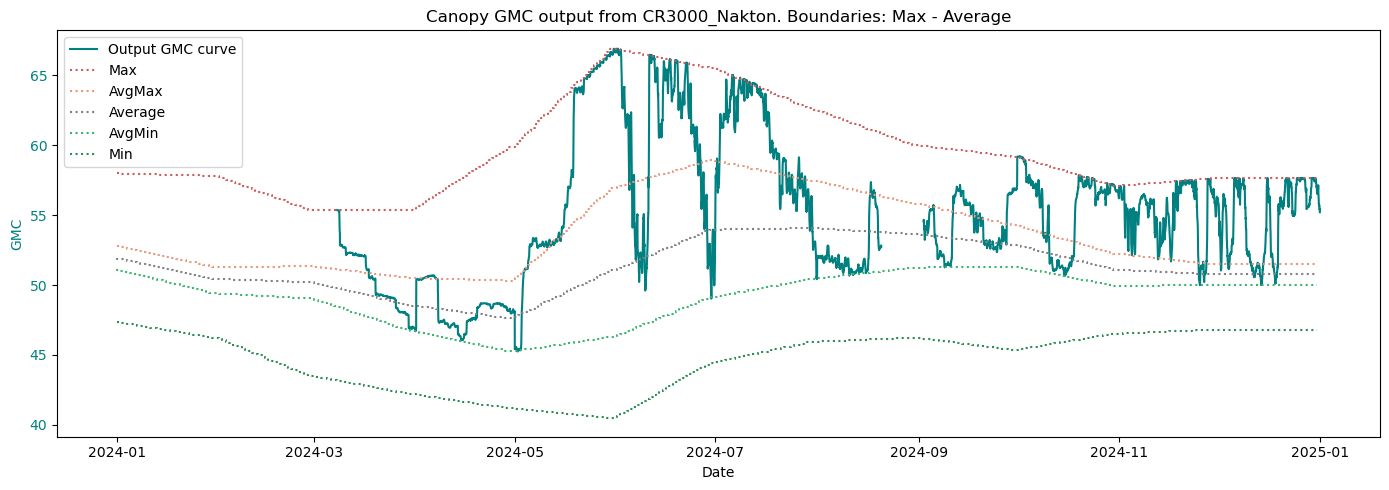

In [42]:
GMC_curve_to_plot = all_cwc_outputs[f'{output_curve_to_lot}'][f'{boundaries}']

def extract_words(column_name):
    possible_words = ['Max', 'Min', 'AvgMin', 'AvgMax', 'Average']
    up, low = None, None
    for word in possible_words:
        if column_name.startswith(word):
            up = word
            column_name = column_name[len(word):]
            break
    for word in possible_words:
        if column_name.startswith(word):
            low = word
            break
    return up, low

boundary_colors = {
    'Max': 'indianred',
    'AvgMax': 'darksalmon',
    'Min': 'seagreen',
    'AvgMin': 'mediumseagreen',
    'Average': 'grey'
}

column_name = GMC_curve_to_plot.name
up, low = extract_words(column_name)

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(all_cwc_outputs[f'{output_curve_to_lot}']['timestamp'], GMC_curve_to_plot, label='Output GMC curve', color='teal')
ax1.set_xlabel('Date')
ax1.set_ylabel('GMC', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')

for col in boundaries_df.columns:
    if col not in ['month']:
        color = boundary_colors.get(col, 'black') 
        ax1.step(boundaries_df.index, boundaries_df[col], label=f'{col}', linestyle='dotted', color=color)

plt.title('Canopy GMC output from CR3000_Nakton. Boundaries: Max - Average')
ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()


# 6. Validate with Field Dara

This section explores the performances of the different constraining parameters by comparing the output with in-situ measurements of canopy GMC. 
The field data was gathered during field campaigns in summer, fall and winter 2024 at the Speulderbos site (Netherlands). 

## 6.1. Load Field data

In [43]:
#load the field data
field_data_path = './Datasets/field_data_speulderbos_2024.xlsx'

def process_gmc_field_data(file_path):
    all_sheets = pd.read_excel(file_path, sheet_name=None)
    df = pd.concat(all_sheets.values(), ignore_index=True)
    df['timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
    df['GMC_Type'] = (df['Wf'] - df['Wd']) / df['Wf'] * 100
    grouped_samples = df.groupby(['timestamp', 'Canopy Level', 'Number'], as_index=False).agg({
        'GMC_Type': 'mean' 
    })
    final_df = grouped_samples.groupby('timestamp', as_index=False).agg({
        'GMC_Type': 'mean'
    })
    final_df.rename(columns={'GMC_Type': 'GMC_field_data'}, inplace=True)
    return final_df
field_data = process_gmc_field_data(field_data_path)
field_data = field_data.sort_values('timestamp')
field_data['campaign_index'] = (field_data['timestamp'].diff().dt.days > 1).cumsum()

print(field_data.head())

            timestamp  GMC_field_data  campaign_index
0 2024-06-25 05:00:00       61.178914               0
1 2024-06-25 09:00:00       61.455457               0
2 2024-06-25 12:00:00       58.208202               0
3 2024-06-25 15:00:00       59.129319               0
4 2024-06-25 18:00:00       56.962959               0


Optional: visualize the all the field data

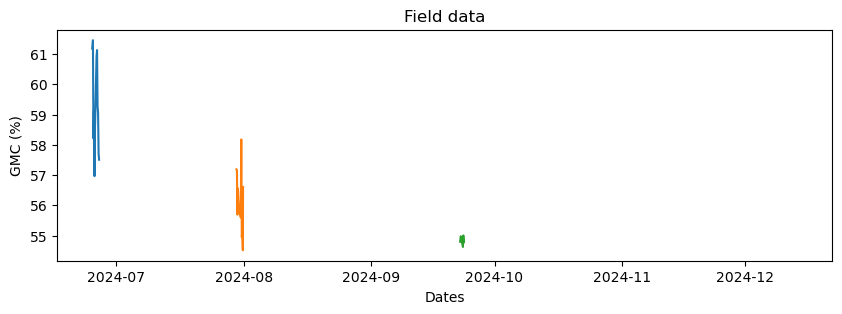

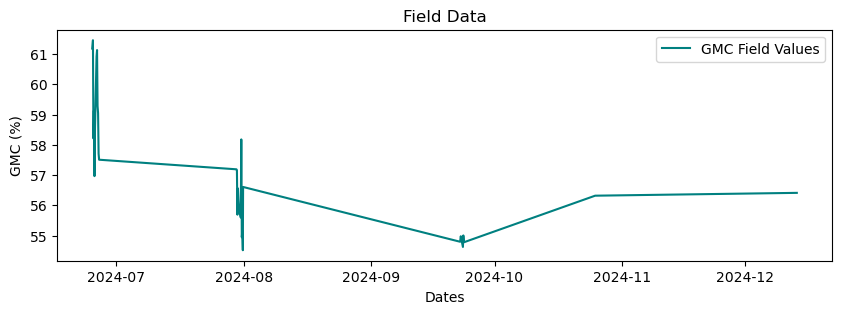

In [44]:
# separated
plt.figure(figsize=(10, 3))
for _, segment in field_data.groupby('campaign_index'):
    plt.plot(segment['timestamp'], segment['GMC_field_data'], linestyle='-', label='GMC Field Values')
plt.xlabel('Dates')
plt.ylabel('GMC (%)')
plt.title('Field data')
plt.show()

#connected
plt.figure(figsize=(10, 3))
plt.plot(field_data['timestamp'], field_data['GMC_field_data'], linestyle='-', color='teal', label='GMC Field Values')
plt.xlabel('Dates')
plt.ylabel('GMC (%)')
plt.title('Field Data')
plt.legend()
plt.show()

Plot individual campaign:

Index fieldwork: 0 = June; 
                1 = July;
                2 = September; 
                3 = October; 
                4 =  December

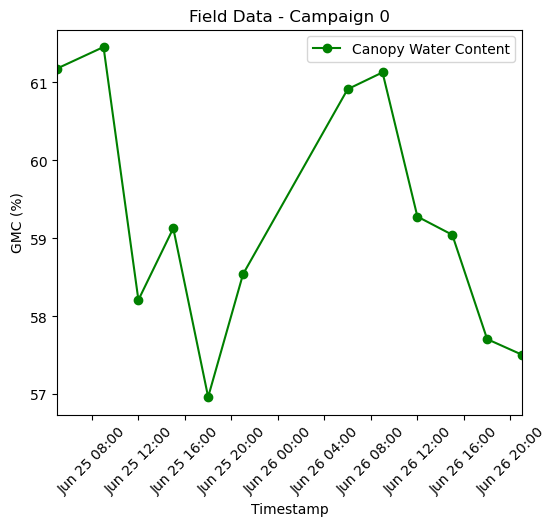

In [45]:
campaign_to_plot = 0  # change as needed

field_data_filtered = field_data[field_data['campaign_index'] == campaign_to_plot]

if not field_data_filtered.empty:
    first_day_dt = field_data_filtered['timestamp'].min()
    last_day_dt = field_data_filtered['timestamp'].max()
    plt.figure(figsize=(6, 5))
    plt.plot(field_data_filtered['timestamp'], field_data_filtered['GMC_field_data'], 
             marker='o', linestyle='-', color='green', label='Canopy Water Content')
    plt.xlabel('Timestamp')
    plt.ylabel('GMC (%)')
    plt.title(f'Field Data - Campaign {campaign_to_plot}')
    plt.xlim(first_day_dt, last_day_dt)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
else:
    print(f"no fieldwork with index {campaign_to_plot}")

## 6.2. Seasonal scale analysis

This code plots all output curves for a given dendrometer and computes statistics on the distance between  the in-situ measurements and predicted canopy GMC values.

In [46]:
output_to_compare = 'CWC_Output_TWD_CR3000_Dendro'
validation_threshold = 1.0 # The threshold for considering a modeled point is whithin reasonable range of the field data values. This is in GMC unit.

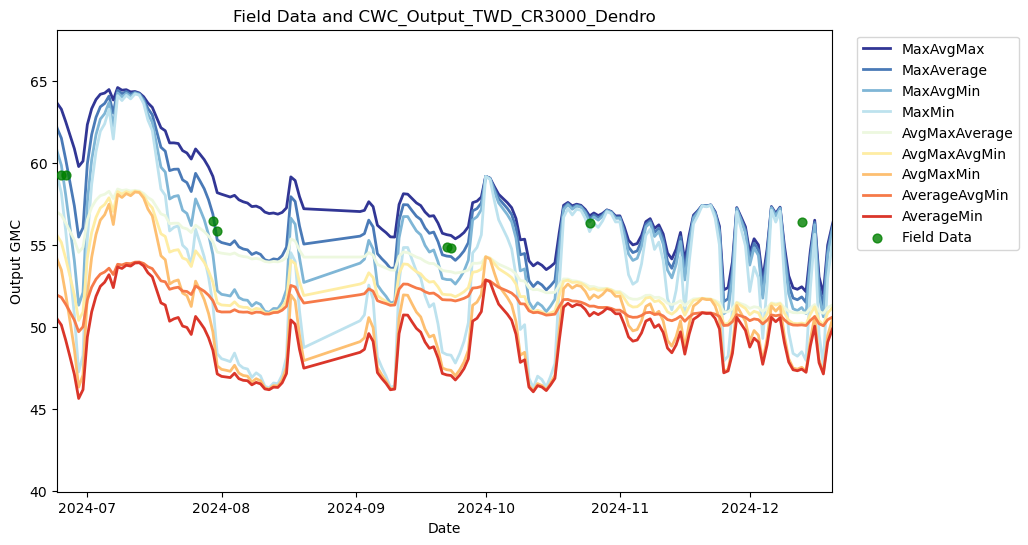


Summary Table:
          Column  Mean Distance  Max Distance  Within Threshold  Rank
1     MaxAverage       1.263830      4.583079                 6   1.0
2      MaxAvgMin       2.089424      5.226930                 2   2.0
0      MaxAvgMax       2.289304      4.035749                 3   3.0
4  AvgMaxAverage       2.523707      5.532114                 0   4.0
5   AvgMaxAvgMin       4.156582      6.175965                 0   5.0
3         MaxMin       4.817995      7.926621                 1   6.0
7  AverageAvgMin       5.347919      7.879742                 0   7.0
6      AvgMaxMin       7.058992      8.875656                 0   8.0
8     AverageMin       8.250328     10.065716                 0   9.0


In [47]:
extracted_part = output_to_compare.split('CWC_Output_')[1] # In order to not plot the original TWD column, this remove the TWD column
columns_to_plot = [
    col for col in all_cwc_outputs[output_to_compare].columns 
    if col not in ['timestamp', extracted_part, 'date']
]

field_data['timestamp'] = pd.to_datetime(field_data['timestamp'])
field_data['date'] = field_data['timestamp'].dt.date
field_data_avg = field_data.groupby('date', as_index=False).agg({'GMC_field_data': 'mean'})

plt.figure(figsize=(10, 6))
color_norm = Normalize(vmin=0, vmax=9)
colors = [cm.RdYlBu_r(color_norm(i)) for i in range(10)]
results = []

for idx, col in enumerate(columns_to_plot):
    original_col_data = all_cwc_outputs[output_to_compare][['timestamp', col]].dropna()
    original_col_data['timestamp'] = pd.to_datetime(original_col_data['timestamp'])
    original_col_data['date'] = original_col_data['timestamp'].dt.date
    original_col_data[col] = pd.to_numeric(original_col_data[col], errors='coerce')
    daily_avg = original_col_data.groupby('date', as_index=False).agg({col: 'mean'})
    
    plt.plot(
        pd.to_datetime(daily_avg['date']),
        daily_avg[col],
        label=f'{col}',
        color=colors[idx],
        linewidth=2
    )
    
    aligned_field = field_data_avg[field_data_avg['date'].isin(daily_avg['date'])]
    aligned_cwc = daily_avg[daily_avg['date'].isin(aligned_field['date'])]
    
    if not aligned_field.empty and not aligned_cwc.empty:
        field_values = aligned_field['GMC_field_data'].values
        curve_values = aligned_cwc[col].values
        
        mean_distance = np.mean(np.abs(field_values - curve_values))
        max_distance = np.max(np.abs(field_values - curve_values))
        within_threshold = sum(1 for d in np.abs(field_values - curve_values) if d < 1)
        results.append({
            'Column': col,
            'Mean Distance': mean_distance,
            'Max Distance': max_distance,
            'Within Threshold': within_threshold,
        })

plt.scatter(
    pd.to_datetime(field_data_avg['date']), 
    field_data_avg['GMC_field_data'], 
    label='Field Data', 
    color='green', 
    alpha=0.8, 
    s=40, 
    zorder=3
)
plt.title(f'Field Data and {output_to_compare}')
plt.xlabel('Date')
plt.ylabel('Output GMC')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.xlim(pd.Timestamp('2024-06-24'), pd.Timestamp('2024-12-20'))
plt.show()

if results:
    results_df = pd.DataFrame(results)
    results_df['Rank'] = results_df['Mean Distance'].rank()  #lower Mean Distance is better
    results_df = results_df.sort_values(by='Rank')
    
    print("\nSummary Table:")
    print(results_df[['Column', 'Mean Distance', 'Max Distance', 'Within Threshold', 'Rank']])
else:
    print("No results to display.")


## 6.3. Sub-Daily scale analysis

### 6.3.1. Viusalize the modelled output with the field data for the 3 field campaigns:

In [48]:
output_to_compare = 'CWC_Output_TWD_CR3000_Nakton'

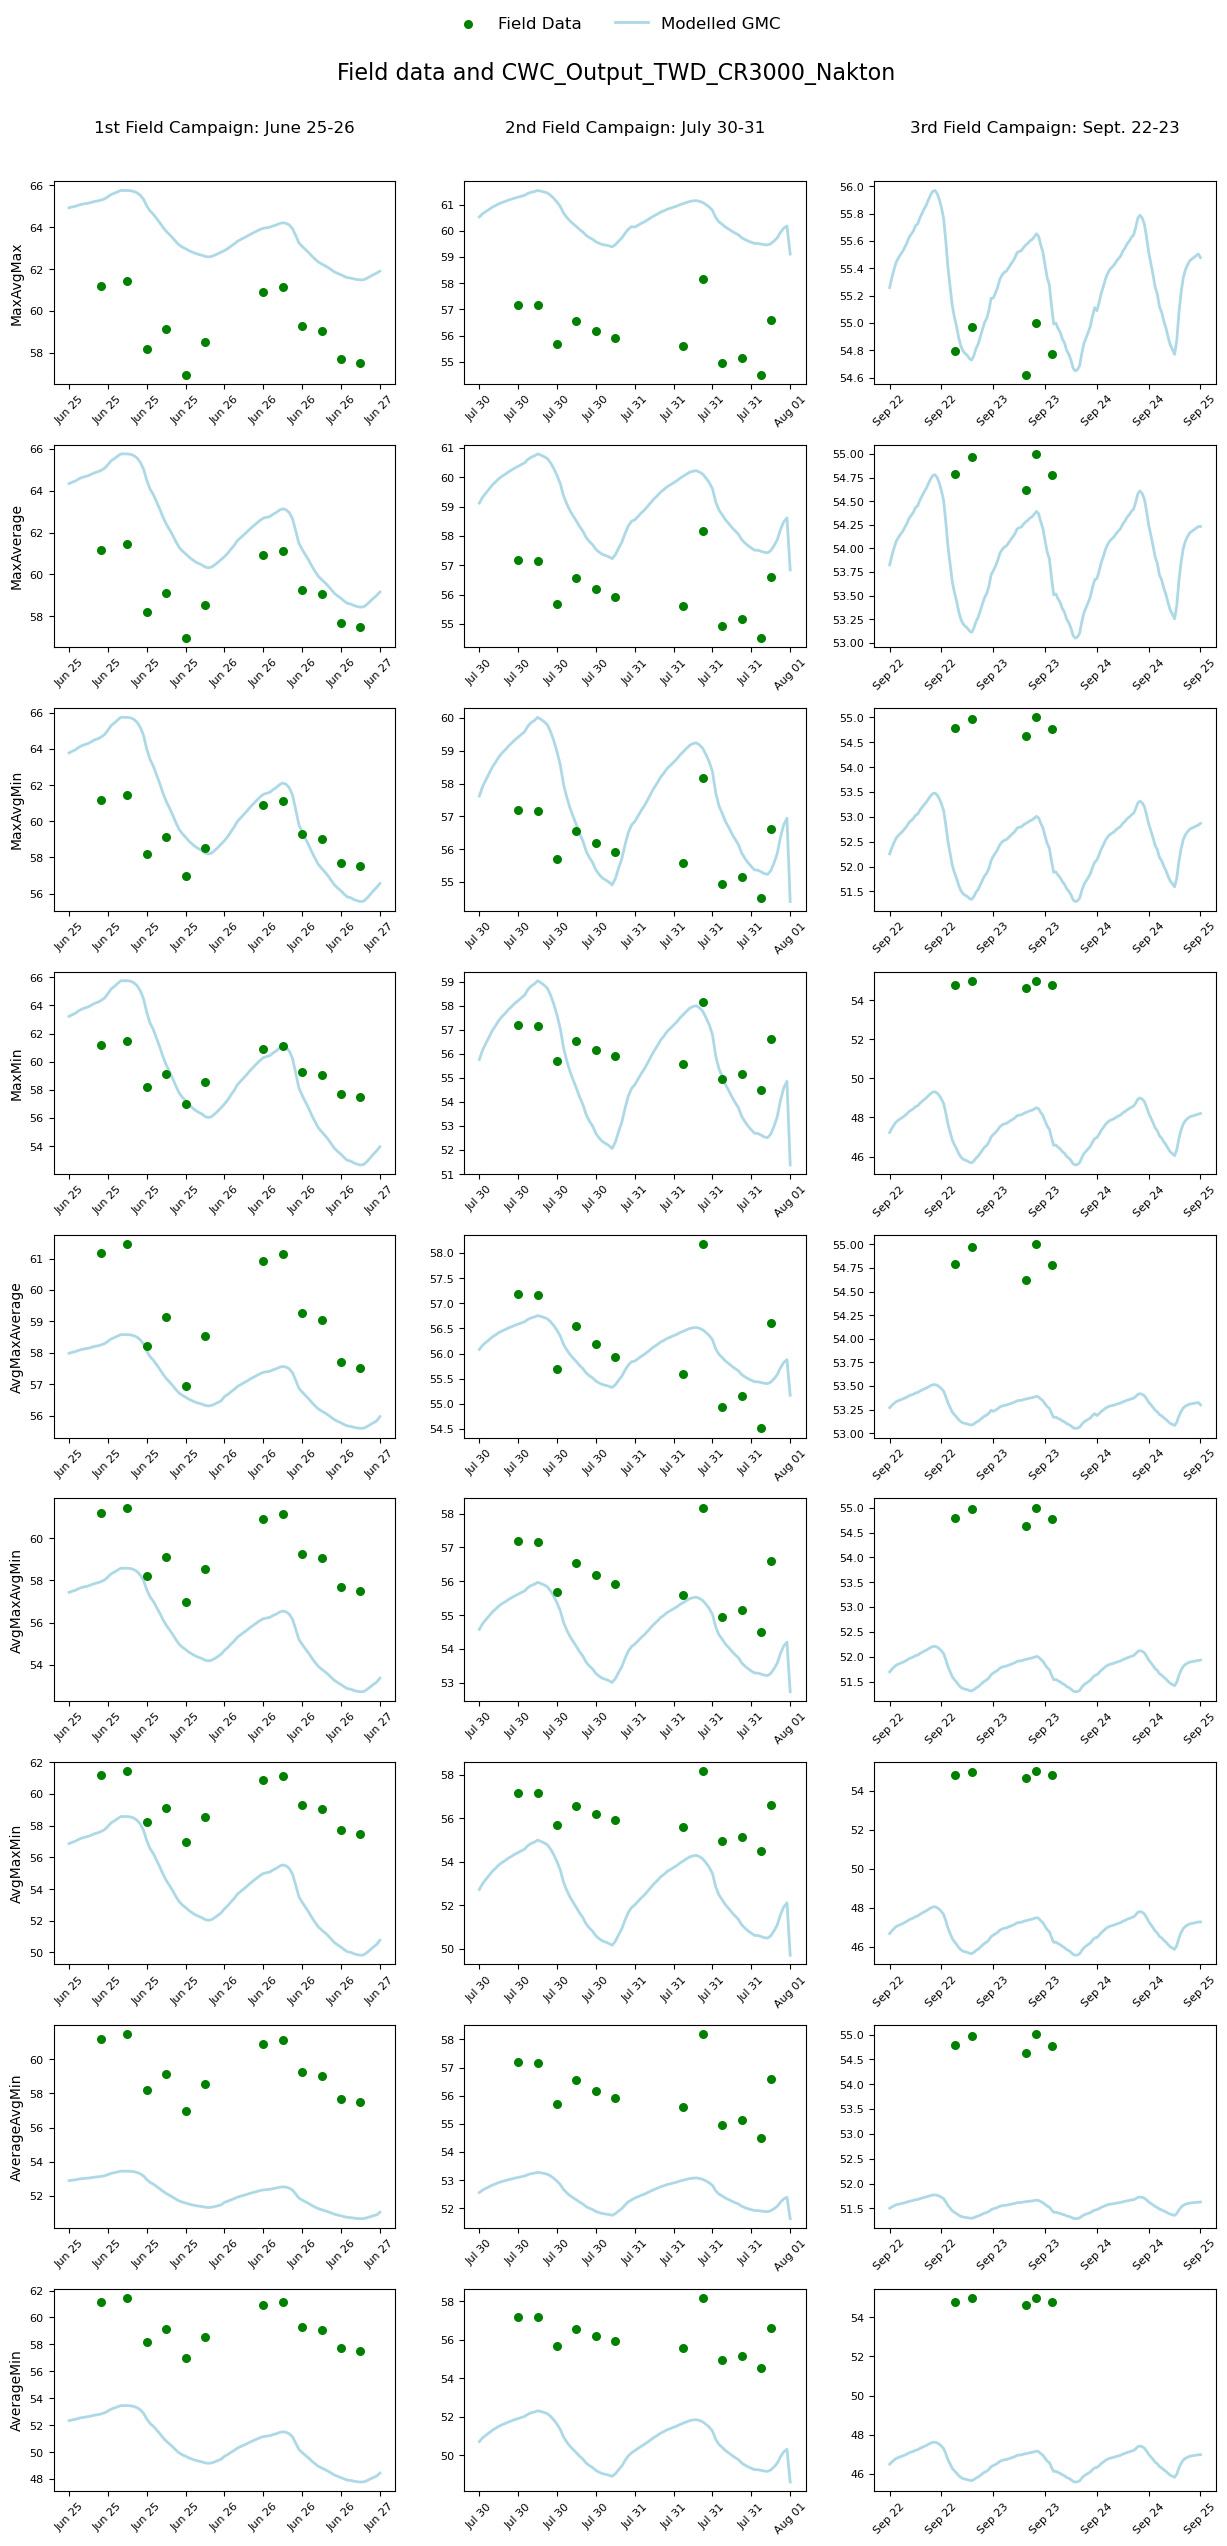

In [49]:
time_ranges = [ #the 4th and 5th field campaign are excluded from the analysis as they contain only 1 sample point, insufficient to grasp sub-daily water variations
    ('2024-06-25', '2024-06-27'), #1st field campaign
    ('2024-07-30', '2024-08-01'), #2nd field campaign
    ('2024-09-22', '2024-09-25')#3rd field campaign
]
field_data['timestamp'] = pd.to_datetime(field_data['timestamp'])

columns_to_analyze = [
    'MaxAvgMax', 'MaxAverage', 'MaxAvgMin', 'MaxMin',
    'AvgMaxAverage', 'AvgMaxAvgMin', 'AvgMaxMin',
    'AverageAvgMin', 'AverageMin'
]

fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 30), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
column_titles = [
    '1st Field Campaign: June 25-26',
    '2nd Field Campaign: July 30-31',
    '3rd Field Campaign: Sept. 22-23'

]
for idx, title in enumerate(column_titles):
    axes[0, idx].set_title(title, fontsize=12, y=1.2)

for row_idx, col in enumerate(columns_to_analyze[:10]): 
    for col_idx, (start_date, end_date) in enumerate(time_ranges):  
        ax = axes[row_idx, col_idx]
        field_data_filtered = field_data[
            (field_data['timestamp'] >= start_date) & (field_data['timestamp'] <= end_date)
        ]
        field_dates = field_data_filtered['timestamp']
        field_values = field_data_filtered['GMC_field_data']

        all_cwc_outputs[output_to_compare]['timestamp'] = pd.to_datetime(all_cwc_outputs[output_to_compare]['timestamp'])
        filtered_cwc_data = all_cwc_outputs[output_to_compare][
            (all_cwc_outputs[output_to_compare]['timestamp'] >= start_date) & 
            (all_cwc_outputs[output_to_compare]['timestamp'] <= end_date)
        ][['timestamp', col]].dropna(subset=[col]) 

        if filtered_cwc_data.empty:
            ax.text(0.5, 0.5, 'No data', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            continue

        ax.scatter(field_dates, field_values, label='Field Data', color='green', s=30, zorder=3)
        ax.plot(filtered_cwc_data['timestamp'], filtered_cwc_data[col], label=f'Modelled GMC', color='lightblue', linewidth=2)

        if col_idx == 0:  
            ax.set_ylabel(f'{col}', fontsize=10)
        ax.tick_params(axis='x', labelrotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

        ax.legend().set_visible(False)

fig.suptitle(f'Field data and {output_to_compare}', fontsize=16, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=12, frameon=False, ncol=2, bbox_to_anchor=(0.5, 0.94))
plt.show()


### 6.3.2. Generate statistics for analysis

This code will generate an excel spreadsheet with statistics for the analysis of the model's performance at the sub-daily scale. The range accuracy and the correlation between modelled output and in-situ measurements is computed.  In addition, to investigate the influence of a potential time shift between stem and canopy water content, a monotonic cross-correlation analysis will be performed to assess the impact of a time shift of the modelled value of 0, 30, 60, 90, 120, 150 and 180 minutes. 
Files will be saved by default in the Datasets/Statistics_Outputs folder.

In [50]:
output_to_analyse = 'CWC_Output_TWD_CR3000_Nakton'

In [51]:
# create the time shifted-outputs

output_to_compare = all_cwc_outputs[output_to_analyse]
extracted_part = "_".join(output_to_analyse.split("_")[2:5])

time_ranges = [ # field Campaign ranges for seperate analysis
    ('2024-06-24', '2024-06-27'), 
    ('2024-07-30', '2024-08-01'), 
    ('2024-09-22', '2024-09-24') 
]

field_data['timestamp'] = pd.to_datetime(field_data['timestamp'])
output_to_compare['timestamp'] = pd.to_datetime(output_to_compare['timestamp'])
columns_to_compare = [col for col in output_to_compare.columns if col != extracted_part]

results = []

shifted_outputs_dict = {}
time_shifts = [0, 30, 60, 90, 120, 150, 180]
shifted_columns_name = ['0', '30', '60', '90', '120', '150', '180']
for index_shift, shift in enumerate(time_shifts):
    shifted_output = output_to_compare.copy()
    shifted_output['timestamp'] = shifted_output['timestamp'] + pd.Timedelta(minutes=shift)
    shifted_outputs_dict[shifted_columns_name[index_shift]] = shifted_output

shifted_filtered = {}
shift_key = ['0', '30', '60', '90', '120', '150', '180']

for skey in shift_key:
    merged_data = pd.merge(
        field_data, 
        shifted_outputs_dict[skey], 
        on='timestamp', 
            how='inner'
    )
    shifted_filtered[skey] = merged_data

for item in shifted_filtered:
    df_now = shifted_filtered[item]
    df_new = df_now.drop(columns=[extracted_part,  'campaign_index'])
    shifted_filtered[item] = df_new


for key in shifted_outputs_dict:
    shifted_outputs_dict[key]['timestamp'] = pd.to_datetime(shifted_outputs_dict[key]['timestamp'])

filtered_outputs_dict = {}
for key, df in shifted_outputs_dict.items():
    filtered_df = df[df['timestamp'].isin(field_data['timestamp'])]
    filtered_df = filtered_df.merge(
        field_data[['timestamp', 'GMC_field_data']],
        on='timestamp',
        how='left'
    )
    filtered_outputs_dict[key] = filtered_df

for key, df in filtered_outputs_dict.items():
    print(f"Filtered DataFrame for {key}:")
    print(df.head()) 

Filtered DataFrame for 0:
            timestamp  TWD_CR3000_Nakton  MaxAvgMax  MaxAverage  MaxAvgMin  \
0 2024-06-25 05:00:00          -2.161351  65.302240   64.979733  64.677115   
1 2024-06-25 09:00:00           0.000000  65.753479   65.753479  65.753479   
2 2024-06-25 12:00:00          -3.516224  65.019376   64.494700  64.002382   
3 2024-06-25 15:00:00          -9.332450  63.805087   62.412539  61.105873   
4 2024-06-25 18:00:00         -13.322602  62.972040   60.984098  59.118758   

      MaxMin  AvgMaxAverage  AvgMaxAvgMin  AvgMaxMin  AverageAvgMin  \
0  64.369823      58.258537     57.955920  57.648628      53.152168   
1  65.753479      58.581045     58.581045  58.581045      53.454786   
2  63.502459      58.056369     57.564051  57.064129      52.962468   
3  59.779023      57.188497     55.881830  54.554980      52.148119   
4  57.224604      56.593104     54.727763  52.833609      51.589445   

   AverageMin  GMC_field_data  
0   52.844876       61.178914  
1   53.454786 

Optional: plot the shifted curves with the field data for visual appreciation

In [52]:
first_shifted_curve = '0' # original
second_shifted_curve = '180' # comparison
output_to_plot = 'MaxAvgMin'
start_date = '2024-06-25'  #define the date range of interest
end_date = '2024-06-27'

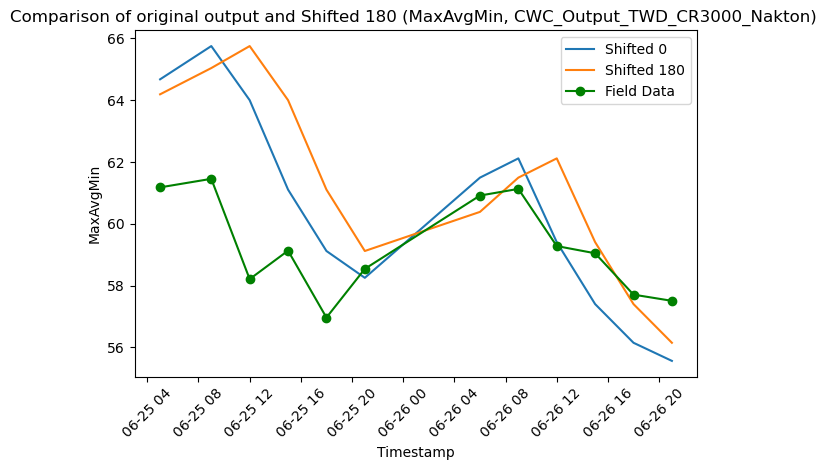

In [53]:
df_1 = filtered_outputs_dict[first_shifted_curve][
    (filtered_outputs_dict[first_shifted_curve]['timestamp'] >= start_date) & 
    (filtered_outputs_dict[first_shifted_curve]['timestamp'] <= end_date)
]
df_2 = filtered_outputs_dict[second_shifted_curve][
    (filtered_outputs_dict[second_shifted_curve]['timestamp'] >= start_date) & 
    (filtered_outputs_dict[second_shifted_curve]['timestamp'] <= end_date)
]

field_data_filtered = field_data[
    (field_data['timestamp'] >= start_date) &
    (field_data['timestamp'] <= end_date)
]

plt.plot(df_1['timestamp'], df_1[output_to_plot], label=f"Shifted {first_shifted_curve}")
plt.plot(df_2['timestamp'], df_2[output_to_plot], label=f"Shifted {second_shifted_curve}")

plt.plot(
    field_data_filtered['timestamp'], 
    field_data_filtered['GMC_field_data'], 
    color='green', 
    label="Field Data",
    marker='o'
)
plt.xlabel('Timestamp')
plt.ylabel(f'{output_to_plot}')
plt.title(f'Comparison of original output and Shifted {second_shifted_curve} ({output_to_plot}, {output_to_analyse}) ')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Generate statistics:

In [54]:
campaign_1 = {}
campaign_2 = {}
campaign_3 = {}

campaign_1_dates = ['2024-06-25', '2024-06-26']
campaign_2_dates = ['2024-07-30', '2024-07-31']
campaign_3_dates = ['2024-09-22 00:00:00', '2024-09-23 13:00:00']

for key, df in filtered_outputs_dict.items():
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    campaign_1[key] = df[(df['timestamp'] >= campaign_1_dates[0]) & (df['timestamp'] <= campaign_1_dates[1])]
    campaign_2[key] = df[(df['timestamp'] >= campaign_2_dates[0]) & (df['timestamp'] <= campaign_2_dates[1])]
    campaign_3[key] = df[(df['timestamp'] >= campaign_3_dates[0]) & (df['timestamp'] <= campaign_3_dates[1])]

def combine_campaign_data(campaign_data):
    combined_df = []
    for key, df in campaign_data.items():
        if not df.empty:
            df['key'] = key 
            combined_df.append(df)
    return pd.concat(combined_df, ignore_index=True) if combined_df else pd.DataFrame()

campaign_1_combined = combine_campaign_data(campaign_1)
campaign_2_combined = combine_campaign_data(campaign_2)
campaign_3_combined = combine_campaign_data(campaign_3)
filtered_outputs_dict_combined = combine_campaign_data(filtered_outputs_dict)

def calculate_stats(df, gmc_column, columns_to_analyze, campaign_index):
    stats = []
    total_points = len(df[gmc_column])

    for column in columns_to_analyze:
        mae = np.mean(np.abs(df[gmc_column] - df[column]))

        mape = np.mean(np.abs((df[gmc_column] - df[column]) / df[gmc_column])) * 100
        
        if df[gmc_column].nunique() > 1 and df[column].nunique() > 1: 
            monotonic_corr = spearmanr(df[gmc_column], df[column])[0]
        else:
            monotonic_corr = np.nan

        field_min, field_max = round(df[gmc_column].min(), 2), round(df[gmc_column].max(), 2)
        model_min, model_max = round(df[column].min(), 2), round(df[column].max(), 2)
        field_range = f"{field_min} - {field_max}"
        model_range = f"{model_min} - {model_max}"

        overlap = max(0, min(field_max, model_max) - max(field_min, model_min)) / (field_max - field_min)

        normalized_deviation = (
            abs(field_max - model_max) + abs(field_min - model_min)
        ) / (field_max - field_min)

        within_1_percent = sum(np.abs((df[gmc_column] - df[column]) / df[column]) <= 0.01)
        within_5_percent = sum(np.abs((df[gmc_column] - df[column]) / df[column]) <= 0.05)

        stats.append({
            "Column": column,
            "Key": None, 
            "MAE": mae,
            "MAPE (%)": mape,
            "Monotonic Correlation": monotonic_corr,
            "Field Range": field_range,
            "Model Range": model_range,
            "Range Overlap": overlap,
            "Normalized Range Deviation": normalized_deviation,
            "Within ±1%": f"{within_1_percent} (out of {total_points})",
            "Within ±5%": f"{within_5_percent} (out of {total_points})",
            "Output Name": output_to_analyse,  # Add output_to_analyse
            "Field Campaign Index": campaign_index  # Add campaign index

        })
    return stats

def analyze_campaign(campaign_data, gmc_column, columns_to_analyze, campaign_index):
    summary_stats = []
    for key, df in campaign_data.items():
        if not df.empty:
            stats = calculate_stats(df, gmc_column, columns_to_analyze, campaign_index)
            for stat in stats:
                stat["Key"] = key 
            summary_stats.extend(stats)
    return pd.DataFrame(summary_stats)

columns_to_analyze = [
    "MaxAvgMax", "MaxAverage", "MaxAvgMin", "MaxMin", "AvgMaxAverage",
    "AvgMaxAvgMin", "AvgMaxMin", "AverageAvgMin", "AverageMin"
]
gmc_column = "GMC_field_data"

campaign_1_stats = analyze_campaign(campaign_1, gmc_column, columns_to_analyze, "Campaign 1")
campaign_2_stats = analyze_campaign(campaign_2, gmc_column, columns_to_analyze, "Campaign 2")
campaign_3_stats = analyze_campaign(campaign_3, gmc_column, columns_to_analyze, "campaing 3")

# Save to Excel
output_file = f"./Datasets/Statistic Outputs/statistics_{output_to_analyse}.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    campaign_1_stats.to_excel(writer, sheet_name="Campaign_1", index=False)
    campaign_2_stats.to_excel(writer, sheet_name="Campaign_2", index=False)
    campaign_3_stats.to_excel(writer, sheet_name="Campaign_3", index=False)

print(f"Summary statistics saved to {output_file}")


Summary statistics saved to ./Datasets/Statistic Outputs/statistics_CWC_Output_TWD_CR3000_Nakton.xlsx


To idenify the best time shift, all statistics have been aglomerated into the all_stat.xlsx file, and the performance compared using this code:

In [55]:
file_path = './Datasets/Statistic Outputs/all_stats.xlsx'

df = pd.read_excel(file_path, usecols=['Column', 'Key', 'MAE', 'Output Name', 'Field Campaign Index'])


df['Key'] = df['Key'].astype(int) 
df_sorted = df.sort_values(by=['Output Name', 'Field Campaign Index', 'Column', 'MAE'])
result = df_sorted.groupby(['Output Name', 'Field Campaign Index', 'Column']).first().reset_index()
result = result[['Output Name', 'Field Campaign Index', 'Column', 'Key', 'MAE']]

most_frequent_key = result['Key'].mode()[0]
key_count = (result['Key'] == most_frequent_key).sum()
print(f"The most frequent Key is {most_frequent_key}, appearing {key_count} times in the results.")
key_counts = result['Key'].value_counts()
most_frequent_keys = key_counts[key_counts == key_counts.max()] 
print("Other Key occurrences:")
for key, count in key_counts.items():
    print(f"Key {key}: {count} times")



The most frequent Key is 180, appearing 41 times in the results.
Other Key occurrences:
Key 180: 41 times
Key 0: 29 times
Key 30: 4 times
Key 120: 3 times
Key 90: 2 times
Key 150: 2 times


# 8. References



Aryal, S., Häusser, M., Grießinger, J., Fan, Z., Bräuning, A., 2020. “dendRoAnalyst”: A tool for processing and analysing dendrometer data. Dendrochronologia 64, 125772. https://doi.org/10.1016/j.dendro.2020.125772

Beck, H.E., Zimmermann, N.E., McVicar, T.R., Vergopolan, N., Berg, A., Wood, E.F., 2018. Present and future Köppen-Geiger climate classification maps at 1-km resolution. Sci Data 5, 180214. https://doi.org/10.1038/sdata.2018.214

Guglielmi, B., 2025. Forest Health Monitoring: Dendrometers as Continuous Canopy Water Content Sensors for the Validation of Microwave Remote Sensing Products. University of Twente, Enschede.

Yebra, M., Scortechini, G., Adeline, K., Aktepe, N., Almoustafa, T., Bar-Massada, A., Beget, M.E., Boer, M., Bradstock, R., Brown, T., Castro, F.X., Chen, R., Chuvieco, E., Danson, M., Değirmenci, C.Ü., Delgado-Dávila, R., Dennison, P., Di Bella, C., Domenech, O., Féret, J.-B., Forsyth, G., Gabriel, E., Gagkas, Z., Gharbi, F., Granda, E., Griebel, A., He, B., Jolly, M., Kotzur, I., Kraaij, T., Kristina, A., Kütküt, P., Limousin, J.-M., Martín, M.P., Monteiro, A.T., Morais, M., Moreira, B., Mouillot, F., Msweli, S., Nolan, R.H., Pellizzaro, G., Qi, Y., Quan, X., Resco De Dios, V., Roberts, D., Tavşanoğlu, Ç., Taylor, A.F.S., Taylor, J., Tüfekcioğlu, İ., Ventura, A., Younes Cardenas, N., 2024. Globe-LFMC 2.0, an enhanced and updated dataset for live fuel moisture content research. Sci Data 11, 332. https://doi.org/10.1038/s41597-024-03159-6

Zweifel, R., Haeni, M., Buchmann, N., Eugster, W., 2016. Are trees able to grow in periods of stem shrinkage? New Phytologist 211, 839–849. https://doi.org/10.1111/nph.13995